# [2] Calculating Rays

## 1. 픽셀 좌표와 월드 좌표 대응하기
NeRF는 장면의 픽셀에서 발사한 광선이 물체와 맞닿는 지점을 예측하여 렌더링을 진행합니다.  
이번 장에서는 카메라 매트릭스로부터 픽셀 좌표를 월드 좌표의 유일한 점으로 대응하고,
이를 이용해 광선의 시작점과 방향을 계산하는 과정을 공부합니다.

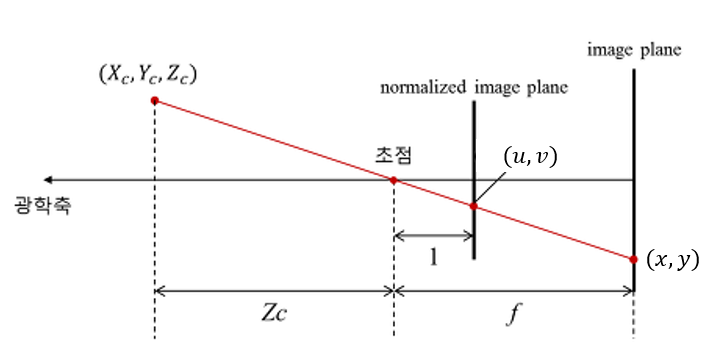

### 1) 픽셀 좌표 $(x,y,1)$ → 정규 좌표 $(u,v,1)$

#### (a) 수식
픽셀 좌표 $(x,y)$가 있을 때, 카메라 내부 행렬 $K$는 다음과 같은 형태를 가정합니다:

$$
K 
= \begin{bmatrix}
f_x & 0   & c_x \\
0   & f_y & c_y \\
0   & 0   & 1
\end{bmatrix}.
$$

그렇다면,

$$
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix}
=
\begin{bmatrix}
f_x & 0   & c_x \\
0   & f_y & c_y \\
0   & 0   & 1
\end{bmatrix}
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix}.
$$

여기서 $(u, v, 1)$는 **정규(normalized) 이미지 평면** 상의 좌표, 흔히 “카메라 좌표($Z=1$) 상의 (u,v)”라고도 말합니다.

#### (b) 역변환
$$
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix}
= 
K^{-1}
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix}.
$$
즉, 
$$
\begin{cases}
u = \frac{x - c_x}{f_x}, \\
v = \frac{y - c_y}{f_y}.
\end{cases}
$$
따라서 픽셀 좌표에서 **주점**($c_x,c_y$)을 빼고, 초점길이($f_x,f_y$)로 나눠주면, $(u,v)$를 얻을 수 있습니다.


### 2) 정규 좌표 $(u,v,1)$ → 카메라 좌표 $(x_c,y_c,z_c)$

이 단계는 “$\mathbf{z}$가 얼마인가?”를 정해야 비로소 3D 점 $\mathbf{X}_c$를 완전히 알 수 있다는 점이 핵심입니다.  
일반적으로, 카메라 좌표계에서 **정규좌표 (u,v,1)는 z=1 평면** 위에 존재한다고 해석하지만, 실제 장면의 한 점은 임의 깊이 $z_c$를 갖습니다.  
예를 들어, NeRF에서는 초점과 정규좌표를 잇는 벡터를 특별한 변환 없이 광선의 방향벡터로 사용하기 위해 **$z_c=-1$** 평면을 사용합니다.

#### (a) 스칼라 $z_c$ 곱
$$
\begin{bmatrix}
x_c \\
y_c \\
z_c
\end{bmatrix}
= z_c \,
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix}.
$$
즉,  
$$
x_c = z_c\,u,\quad
y_c = z_c\,v,\quad
z_c = z_c.
$$

- 실제로는 “해당 픽셀 $(x,y)$”가 어느 깊이 $z_c$를 갖는지 알아야, $(x_c,y_c,z_c)$가 **유일**하게 결정됩니다.  
- 예: NeRF의 경우 **z=-1** 입니다.


### 3) 카메라 좌표 $X_c = (x_c,y_c,z_c)$ → 월드 좌표 $X_w = (x_w,y_w,z_w)$

#### (a) 카메라 외부행렬
카메라 외부 행렬(Extrinsic Matrix)은 **세계 좌표계** 에서 **카메라 좌표계** 로 변환하는 행렬 **(World to Cam)** 이며, 회전 행렬 $ R $ 과 이동 벡터 $ t $ 를 포함합니다.

이 행렬을 동차 좌표계 형태(4×4 행렬)로 나타내면 다음과 같습니다:

$$
T_{wc} =
\begin{bmatrix}
R & t \\
0 & 1
\end{bmatrix}
$$

여기서,
- $ R \in \mathbb{R}^{3 \times 3} $ : 회전 행렬 (세계 좌표 → 카메라 좌표 변환)
- $ t \in \mathbb{R}^{3 \times 1} $ : 이동 벡터 (세계 좌표계에서의 카메라 위치)

즉, $ T_{wc} $ 를 사용하면 세계 좌표계의 한 점 $ X_w $ 를 카메라 좌표계의 점 $ X_c $ 로 변환할 수 있습니다:

$$
X_c = T_{wc} X_w
$$

(동차 좌표계를 사용하여 $ X_w = [x_w, y_w, z_w, 1]^T $ 형태로 표현)

#### (b) 카메라 외부 행렬의 역행렬
카메라 외부 행렬 $ T_{wc} $ 의 역행렬 $ T_{cw} $은 **카메라 좌표계**를 **세계 좌표계**로 변환하는 행렬 **(Cam to World)** 행렬입니다.  
따라서 이 행렬은 다음과 같습니다.

$$
T_{cw} =
\begin{bmatrix}
R & t \\
0 & 1
\end{bmatrix}^{-1} =
\begin{bmatrix}
R^T & -R^T t \\
0 & 1
\end{bmatrix}
$$

여기서,
- $ R^T $ : $ R $ 의 전치 행렬 (회전을 반대로 적용)
- $ -R^T t $ : 카메라의 이동을 반대로 적용

즉, 위에서 구한 카메라 좌표 $X_c$에서 세계 좌표 $X_w$로 변환하는 공식은 아래와 같습니다.

$$
X_w = T_{cw} X_c
$$

이를 통해 현실 세계의 좌표 $X_w$를 계산할 수 있습니다.

### 4) 전체 과정 수식 요약

“픽셀 $(x,y)$에서 3D 장면 좌표 $(x_w,y_w,z_w)$를 구한다면”:

1. **픽셀->정규화** ($K^{-1}:$카메라 내부 행렬의 역행렬)
   $$
   \begin{bmatrix}u\\v\\1\end{bmatrix}
   = K^{-1} \begin{bmatrix}x\\y\\1\end{bmatrix}.
   $$

2. **Z(깊이) 곱**
   $$
   \begin{bmatrix}x_c\\y_c\\z_c\end{bmatrix}
   = z_c \begin{bmatrix}u\\v\\1\end{bmatrix}.
   $$
   여기서 $z_c$는 평면의 깊이 값

3. **카메라->월드**($T_{cw}:$카메라 외부 행렬 역행렬)
   $$
   \begin{bmatrix}x_w\\y_w\\z_w\\1\end{bmatrix}
   = T_{cw}\begin{bmatrix}x_c\\y_c\\z_c\\1\end{bmatrix}
   $$

이렇게 3단계를 거쳐 $(x,y,1)$ → $(u,v,1)$ → $(x_c,y_c,z_c, 1)$ → $(x_w,y_w,z_w, 1)$가 결정됩니다.

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pytransform3d.transformations as pt

In [3]:
# 텐서로 이루어진 픽셀 좌표계 만들어보기
W = 6
H = 4
# torch.linspace(0,W-1,W): 0, 1, 2, ... W-1
# 0부터 W-1까지 W개의 1D 텐서 (W = 5: [0, 1, 2, 3, 4])
i, j = torch.meshgrid(torch.linspace(0,W-1,W), torch.linspace(0, H-1, H))
# 두 개의 1D 텐서를 받아, 2D 격자 좌표 i, j를 생성.
# 첫 번째 인자(가로축), 두 번째 인자(세로축)에 대응하는 모든 조합의 좌표를 만들어낸다.
# 여기서는 (x, y) 대신 (i, j)를 두 변수로 받고 있음.
# 결과적으로 i, j는 shape가 (W, H) 또는 (H, W) 형태의 2D 텐서.
# 주의: PyTorch torch.meshgrid의 인자 순서에 따라, 결과 텐서의 shape 순서가 (rows, cols) 혹은 (cols, rows)가 달라질 수 있으니, 보통은 (y, x) 순서로 호출하는 관습이 많습니다.

print(i)
print(j)

# i와 j를 전치해서, (W×H) 격자의 축을 원하는 대로 맞추는 과정.
i = i.t()
j = j.t()

print(i) # x좌표
print(j) # y좌표

grid = torch.stack([i, j], -1)
# 텐서 i, j를 마지막 차원에 새 축으로 쌓음.
# 즉, 각 픽셀 위치마다 (i, j) 두 좌표를 [i, j] 형태로 묶어, shape가 (H, W, 2)인 텐서가 됩니다.
# 예: grid[y, x] = [i_value, j_value].
print(grid[0]) # y = 0인 픽셀 좌표
print(grid[1]) # y = 1인 픽셀 좌표
print(grid[0][1]) # (x, y) = (0, 1)

tensor([[0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [2., 2., 2., 2.],
        [3., 3., 3., 3.],
        [4., 4., 4., 4.],
        [5., 5., 5., 5.]])
tensor([[0., 1., 2., 3.],
        [0., 1., 2., 3.],
        [0., 1., 2., 3.],
        [0., 1., 2., 3.],
        [0., 1., 2., 3.],
        [0., 1., 2., 3.]])
tensor([[0., 1., 2., 3., 4., 5.],
        [0., 1., 2., 3., 4., 5.],
        [0., 1., 2., 3., 4., 5.],
        [0., 1., 2., 3., 4., 5.]])
tensor([[0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3., 3.]])
tensor([[0., 0.],
        [1., 0.],
        [2., 0.],
        [3., 0.],
        [4., 0.],
        [5., 0.]])
tensor([[0., 1.],
        [1., 1.],
        [2., 1.],
        [3., 1.],
        [4., 1.],
        [5., 1.]])
tensor([1., 0.])


In [4]:
# Ray helpers
def get_rays(H, W, K, c2w):
    i, j = torch.meshgrid(torch.linspace(0, W-1, W), torch.linspace(0, H-1, H))
    i = i.t()
    j = j.t()
    # Image Coordinate to Normalized Coordinate
    # 이 때, NeRF는 위의 이미지와 다르게 Normalized Plane이 Z = -1인 곳에 존재한다
    # 따라서 y값에 전체 -를 해주는 것, z 좌표는 -1인 것. -> -(j-K[1][2])/K[1][1], -torch.ones_like(i)], -1
    dirs = torch.stack([(i-K[0][2])/K[0][0], -(j-K[1][2])/K[1][1], -torch.ones_like(i)], -1) # (H, W, 3)
    
    rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1) # c2w @ dir  c2w.dot(dir) dot product, equals to: [c2w.dot(dir) for dir in dirs]
    # Translate camera frame's origin to the world frame. It is the origin of all rays.
    # dirs[..., np.newaxis, :] → shape이 (H,W,1,3).
    # c2w[:3,:3] → shape이 (3,3).
    # 곱셈에서 두 텐서가 “(H, W, 1, 3) × (3, 3)”으로 브로드캐스트되어,
    # 사실상 dirs×R 연산이 이루어짐.
    # 그 뒤 np.sum(..., -1)로 마지막 축(3)을 합쳐서 (H,W,3) 결과를 얻음.
    # 이는 “원소별 곱 + 합” = “행렬 곱” 과 동일한 효과.

    rays_o = c2w[:3, -1].expand(rays_d.shape)
    # c2w[:3, -1]는 3D 벡터(카메라의 월드 좌표 원점).
    # expand(rays_d.shape)로 shape (H,W,3)로 늘림:
    # 결국 모든 픽셀에서의 광선 시작점(origin)은 동일한 카메라 위치를 공유.
    # 따라서 rays_o[y, x] = 카메라 원점(월드 좌표)

    # rays_o: shape (H, W, 3), 모든 픽셀이 공유하는 카메라 원점 위치
    # rays_d: shape (H, W, 3), 각 픽셀별 광선 방향
    
    return rays_o, rays_d

def get_rays_np(H, W, K, c2w):
    i, j = np.meshgrid(np.arange(W, dtype=np.float32), np.arange(H, dtype=np.float32), indexing='xy')
    dirs = np.stack([(i-K[0][2])/K[0][0], -(j-K[1][2])/K[1][1], -np.ones_like(i)], -1)
    # Rotate ray directions from camera frame to the world frame
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
    # Translate camera frame's origin to the world frame. It is the origin of all rays.
    rays_o = np.broadcast_to(c2w[:3,-1], np.shape(rays_d))
    return rays_o, rays_d

### 5) 픽셀 좌표계와 정규 좌표계 가시화
아래의 예시는 픽셀 좌표계와 정규 좌표계가 NeRF에서 어떻게 바뀌는지 가시화해본 것입니다.  
두 좌표계의 원점의 위치가 다른데 반해 이를 하나의 공간에 그려 핀홀 카메라의 완벽한 기하를 구현하진 못했습니다.  
그러나 각 점이 초점을 지나 어떻게 대응되는지, 좌표의 값은 살펴볼 수 있습니다.  

torch.Size([4, 6, 3])


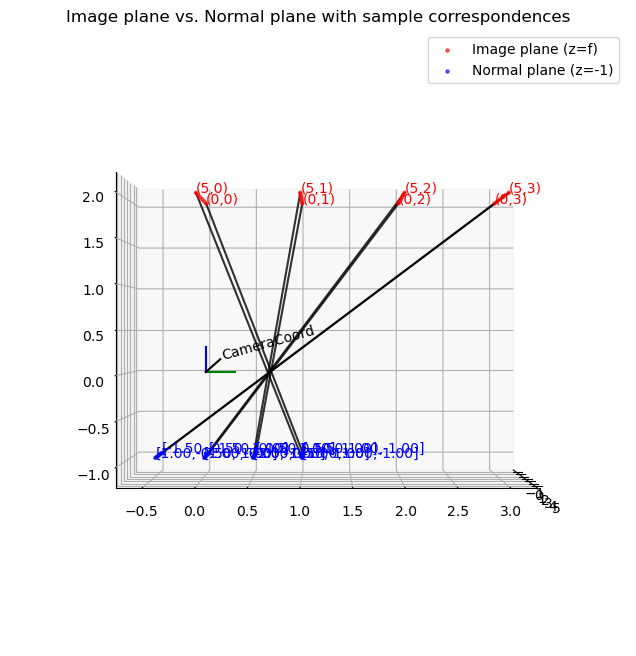

In [5]:
def visualize_image_plane_3d(H, W, K, sample_points=None):
    """
    - 이미지 평면: z=f (f=fx), (x=i, y=j)
    - 노멀 평면: z=-1, (x=(i-cx)/fx, y=-(j-cy)/fy)
    
    - 두 평면 모두 로컬 카메라 좌표계에서만 그림(no c2w).
    - sample_points: [(i1,j1), (i2,j2), ...] 형태로 
      특정 픽셀 좌표를 골라 대응점을 연결해준다.
    """

    if sample_points is None:
        # 디폴트로는 네 구석 픽셀 + 중앙 픽셀 정도만 예시로 표시
        sample_points = [
            (0, 0),
            (W-1, 0),
            (0, H-1),
            (W-1, H-1),
            (int(W//2), int(H//2))
        ]

    # 이미지 플레인의 좌표 지정
    i, j = torch.meshgrid(
        torch.linspace(0, W-1, W),
        torch.linspace(0, H-1, H)
    )
    i = i.t()
    j = j.t()

    img_plane_x = i
    img_plane_y = j
    img_plane_z = torch.full_like(i, K[0][0]) # z는 focal length x로 가정 (어차피 focal length x와 focal length y는 동일한 값이므로)
    img_plane = torch.stack([img_plane_x, img_plane_y, img_plane_z], dim=-1)  # (H,W,3)
    img_plane_flat = img_plane.view(-1, 3).cpu().numpy()

    # 노멀 플레인의 좌표 지정
    dirs = torch.stack([(i-K[0][2])/K[0][0], -(j-K[1][2])/K[1][1], -torch.ones_like(i)], -1)
    dirs_flat = dirs.view(-1, 3).cpu().numpy()

    print(dirs.shape)

    # --- 시각화 시작 ---
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')

    # (A) 카메라 좌표축 표시
    pt.plot_transform(ax=ax, A2B=np.eye(4), s=0.3, name="CameraCoord")

    # (B) 이미지 평면 산점도 (빨강)
    ax.scatter(img_plane_flat[:, 0],
               img_plane_flat[:, 1],
               img_plane_flat[:, 2],
               c='red', s=5, alpha=0.6, label="Image plane (z=f)")

    # (C) 노멀 평면 산점도 (파랑)
    ax.scatter(dirs_flat[:, 0],
               dirs_flat[:, 1],
               dirs_flat[:, 2],
               c='blue', s=5, alpha=0.6, label="Normal plane (z=-1)")

    # (D) 대응점 표시 및 직선 연결
    for (i_p, j_p) in sample_points:
        # 이미지 평면에서의 3D 좌표
        # z=f, x=i, y=j
        img_x = i_p
        img_y = j_p
        img_z = fx
        # 노멀 평면에서의 3D 좌표
        nor_x = (i_p - cx)/fx
        nor_y = -(j_p - cy)/fy
        nor_z = -1

        # 직선으로 연결
        Xs = [img_x, nor_x]
        Ys = [img_y, nor_y]
        Zs = [img_z, nor_z]
        ax.plot(Xs, Ys, Zs, c='black', alpha=0.8)

        # 텍스트 라벨 (예: "(0,0)->(-cx/f, -cy/f,-1)")
        ax.text(img_x, img_y, img_z,
                f"({i_p},{j_p})",
                color='red')
        ax.text(nor_x, nor_y, nor_z,
                f"[{nor_x:.2f},{nor_y:.2f},{nor_z:.2f}]",
                color='blue')

    # 보기 편하게 범위 설정
    # max_val = max(W, H, fx.item()+5)  # 대충 넉넉히
    # ax.set_xlim([-max_val, max_val])
    # ax.set_ylim([-max_val, max_val])
    # ax.set_zlim([-max_val, max_val])
    # ax.set_box_aspect((1,1,1))

    ax.view_init(elev=0, azim=0)
    ax.legend()
    plt.title("Image plane vs. Normal plane with sample correspondences")
    plt.show()


# --------------------------
# 사용 예시
# --------------------------
if __name__ == "__main__":
    import torch

    H, W = 4, 6
    fx = 2.0
    fy = 2.0
    cx = W/2
    cy = H/2
    K = torch.tensor([
        [fx, 0,  cx],
        [0,  fy, cy],
        [0,  0,   1 ]
    ], dtype=torch.float32)

    # 원하는 (i,j) 좌표를 골라 연결
    sample_pts = [(0, 0), (0, 1), (0, 2), (0, 3), (5, 0), (5, 1), (5, 2), (5, 3)]
    # sample_pts = [(0,0), (W-1,0), (0,H-1), (W-1,H-1), (2,2)]

    visualize_image_plane_3d(H, W, K, sample_points=sample_pts)


## 2. Normalized Device Coordinates(NDC) 개념

컴퓨터 그래픽스에서 3D 장면을 그릴 때, 뷰 프러스텀을 정육면체 모양으로 정규화하는 것을 말합니다. 아래 내용은 **NeRF의 `ndc_rays`** 변환에서 쓰이는 수식을 보다 **기하학적으로** 해석한 것입니다.  
특히 **Forward-facing**(정면 카메라) 장면을 가정하고, **카메라가 $-z$ 방향**을 바라보며,  
$\text{near}$ plane을 $z=-n$ 근방에 두었을 때, 광선($\mathbf{o}, \mathbf{d}$)을 **NDC**(Normalized Device Coordinates) 공간으로 맵핑하는 과정을 설명합니다.


### 1) 배경: Forward-facing 카메라와 NDC

1. 카메라가 $(0,0,0)$에 있고, $-z$ 방향을 바라본다고 합시다.  
2. 물체는 $z < 0$에 존재(즉, 카메라 앞).  
3. **Near plane**는 $z=-n$($n>0$)이고, 카메라보다 조금 떨어진 지점.  
4. NDC에서는 $-z$ 영역을 $(-1,1)$ 범위로 압축해, 그래픽스 파이프라인에서 “$(x,y,z)\in[-1,1]^3$”로 관리.

이때, $\mathbf{o}=(o_x,o_y,o_z)$와 $\mathbf{d}=(d_x,d_y,d_z)$ (각각 월드 좌표에서의 광선 원점·방향)이 있을 때, NeRF 구현은 아래와 같은 수식으로 $\mathbf{o}', \mathbf{d}'$를 구합니다:

$$
\begin{aligned}
\mathbf{o}' &= 
\begin{pmatrix}
-\dfrac{f_\mathrm{cam}}{W/2}\,\dfrac{o_x}{o_z} \\[6pt]
-\dfrac{f_\mathrm{cam}}{H/2}\,\dfrac{o_y}{o_z} \\[6pt]
1 + \dfrac{2\,n}{o_z}
\end{pmatrix}, \\[1em]
\mathbf{d}' &= 
\begin{pmatrix}
-\dfrac{f_\mathrm{cam}}{W/2}\biggl(\dfrac{d_x}{d_z} - \dfrac{o_x}{o_z}\biggr) \\[6pt]
-\dfrac{f_\mathrm{cam}}{H/2}\biggl(\dfrac{d_y}{d_z} - \dfrac{o_y}{o_z}\biggr) \\[6pt]
-\,2\,n\,\dfrac{1}{\,o_z\,}
\end{pmatrix}.
\end{aligned}
$$


여기서

- $f_\mathrm{cam}$는 (NeRF 코드에서) “카메라 초점거리”  
- $W, H$는 화면(이미지) 해상도  
- $n$은 near plane 거리($z=-n$).


### 2) 수식 유도 개괄

1. **Near plane로 광선 원점을 맞추기**  
   - 먼저, $z=-n$에 해당하는 지점으로 광선 원점을 $\mathbf{o}$에서 평행 이동.  
   - NeRF 코드에서
     $$
       t = \dfrac{-(n + o_z)}{d_z}, 
       \quad
       \mathbf{o} \leftarrow \mathbf{o} + t\,\mathbf{d}.
     $$
   - 다만, 위 그림(수식)에서는 이 과정을 “결과적으로 $o_z$가 -n에 가까워지는 형태”로 간주.

2. **투영**: $\displaystyle x' = -\dfrac{2\,f_\mathrm{cam}}{W}\;\dfrac{x}{z}, \quad y' = -\dfrac{2\,f_\mathrm{cam}}{H}\;\dfrac{y}{z}$.  
   - $-\frac{x}{z}$ 하는 이유: 카메라가 -z를 보고 있기 때문에, 원근 투영 시 $\frac{x}{|z|}$ 비율로 x가 확장.  
   - $\frac{W}{2\,f_\mathrm{cam}}$ 등으로 $[-1,1]$ 범위로 스케일링.  
3. **z 축 정규화**: $z' = 1 + \dfrac{2\,n}{z}$.  
   - $z=-n$이면 $z'=+1$,  
   - $z\to -\infty$이면 $z' \to -1$.  
   - 이렇게 $[-n,\infty)$ 구간을 $[+1, -1]$로 매핑.

이제 $\mathbf{o}'$는 $(x',y',z')$ 형태가 되고, $\mathbf{d}'$는 “NDC에서 광선 방향”으로 같은 변환(미분값)을 적용한 것입니다.  
즉,
$$
\mathbf{d}' = \Bigl(\mathbf{o} + \mathbf{d}\Bigl)'\;-\;\mathbf{o}' \quad \text{(아이디어)}
$$
를 코드로 옮기면 $\frac{d_x}{d_z}-\frac{o_x}{o_z}$ 꼴이 나옵니다.

### 3) 항목별 해석

#### (a) $-\dfrac{f_\mathrm{cam}}{W/2}\,\dfrac{o_x}{o_z}$

- 원근 투영 시, $\frac{x}{z}$가 시야각에 비례.  
- “$\frac{W}{2}$”와 “$f_\mathrm{cam}$”가 곱해져서 “얼마만큼 -1..+1 범위로 매핑할지” 결정.  
- 부호가 `-`인 이유는 카메라가 -z축을 바라보고 있으므로, x/z를 양의 x축 증가 방향으로 놓으면 “뒤집힘”이 발생.

#### (b) $1 + \dfrac{2\,n}{o_z}$

- **z'** 성분.  
- z=-n일 때 $z'=+1$, z\to-\infty일 때 $z'=-1$.  
- 이는 OpenGL의 퍼스펙티브 투영 방정식과 유사한 형태(단, 실제 OpenGL은 보통 $[-1,1]\to[near,far]$).

#### (c) $\dfrac{d_x}{d_z} - \dfrac{o_x}{o_z}$

- 광선 방향을 단순히 $\frac{d_x}{d_z}$로만 변환하면, 원점 $\mathbf{o}$가 이미 z<0 쪽으로 이동했음을 감안해야 합니다.  
- 따라서 $\bigl(\frac{o_x + d_x}{o_z + d_z}\bigr) - \bigl(\frac{o_x}{o_z}\bigr)\approx \frac{d_x}{d_z}-\frac{o_x}{o_z}$ 식이 성립(1차 근사).  
- 구현 코드에서는 `rays_d[...,0]/rays_d[...,2] - rays_o[...,0]/rays_o[...,2]`와 동일.


### 4) 해석: 왜 이런 변환을 쓰는가?

NeRF의 오리지널 코드(“forward-facing” 데이터셋)에서,
- “카메라가 한 방향(-z)으로만 찍혔다.”
- “멀리 있는 점들”을 $[-1,1]$ 범위에 매핑해 **샘플링**을 단순화한다.

그 결과,
- $\mathbf{o}',\mathbf{d}'$가 $\text{NDC}$라는 3D 박스($[-1,1]^3$) 안에 들어가서,  
- z축도 $\in [-1,1]$ 범위가 되므로,  
- 레이 샘플링을 할 때, 근거리/원거리를 한 번에 처리하기 편해집니다.


### 5) 그림으로 요약

- 원점 $\mathbf{o}$(월드 좌표)와 방향 $\mathbf{d}$가 있을 때,  
  1. **near plane**로 이동하여 $z=-n$ 근방까지 당김( `$\mathbf{o}\leftarrow \mathbf{o}+t\mathbf{d}$` ).  
  2. $\bigl(x, y, z\bigr)\mapsto \bigl(x', y', z'\bigr)$ = 
     $$
     \begin{cases}
     x' = -\frac{2\,f}{W}\frac{x}{z},\;
     y' = -\frac{2\,f}{H}\frac{y}{z},\;
     z' = 1 + \frac{2\,n}{z},
     \end{cases}
     $$
     로 변환.  
  3. 방향벡터는 $\mathbf{d}' = \bigl(\mathbf{o}+\mathbf{d}\bigr)' - \mathbf{o}'\approx\ldots$.

그렇게 해서 **$\mathbf{o}',\mathbf{d}'$**를 얻는다. 식으로 쓰면, 질문에 나온 수식과 정확히 부합합니다.

In [6]:
# [-n, ~)에 존재하는 X, Y, Z 좌표를 [-1, 1] 사이로 정규화
def ndc_rays(H, W, focal, near, rays_o, rays_d):
    # Shift ray origins to near plane
    t = -(near + rays_o[...,2]) / rays_d[...,2]
    rays_o = rays_o + t[...,None] * rays_d
    
    # Projectionㅌ
    o0 = -1./(W/(2.*focal)) * rays_o[...,0] / rays_o[...,2]
    o1 = -1./(H/(2.*focal)) * rays_o[...,1] / rays_o[...,2]
    o2 = 1. + 2. * near / rays_o[...,2]

    d0 = -1./(W/(2.*focal)) * (rays_d[...,0]/rays_d[...,2] - rays_o[...,0]/rays_o[...,2])
    d1 = -1./(H/(2.*focal)) * (rays_d[...,1]/rays_d[...,2] - rays_o[...,1]/rays_o[...,2])
    d2 = -2. * near / rays_o[...,2]
    
    rays_o = torch.stack([o0,o1,o2], -1)
    rays_d = torch.stack([d0,d1,d2], -1)
    
    return rays_o, rays_d